최하연의 브랜치

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from math import pi
from pandas.plotting import parallel_coordinates

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕'이 설치되어 있을 경우
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 부호 깨짐 방지

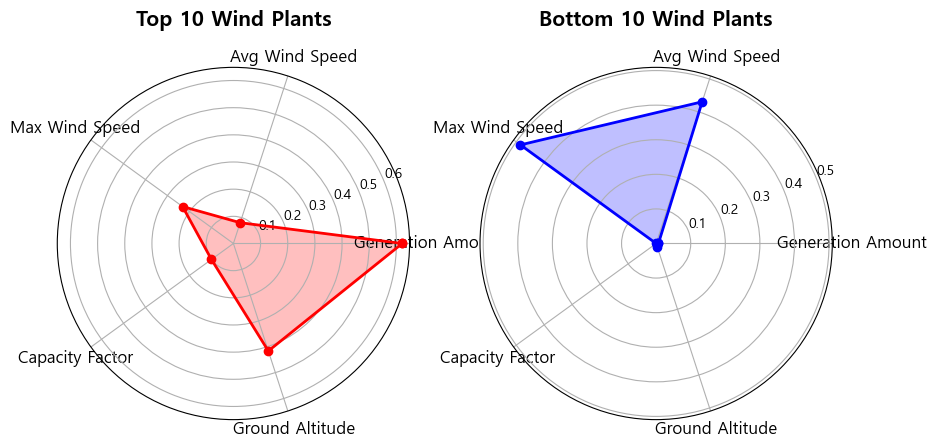

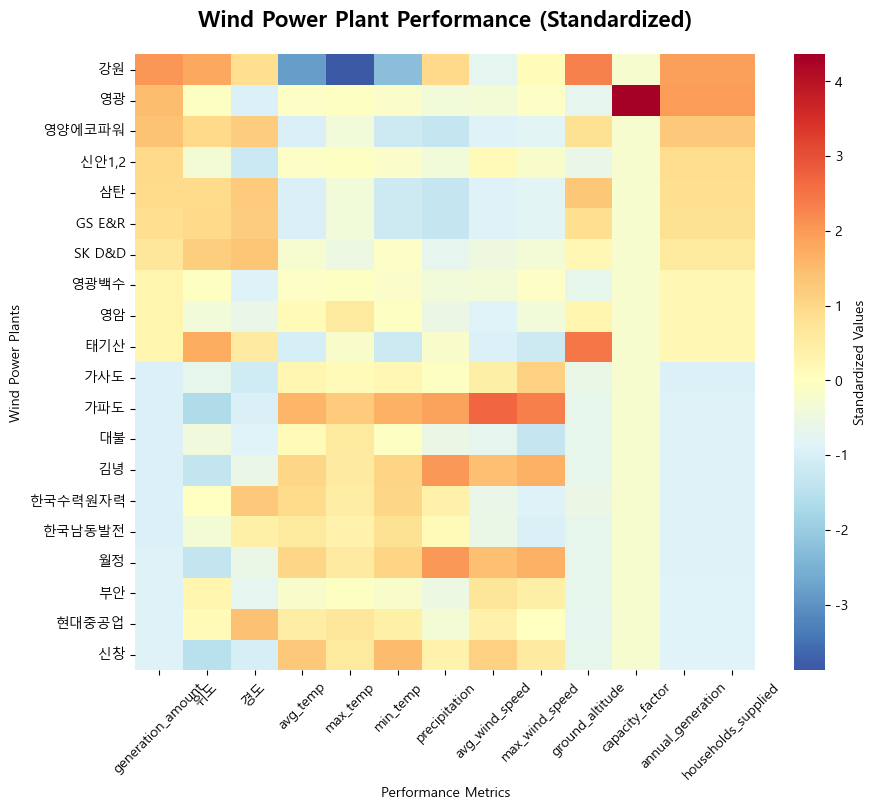

In [ ]:
# 엑셀 데이터 불러오고 컬럼명 변경, 상하위 10개 선정
def load_excel_data(existing_file_path='wind_atlas_original.xlsx', new_sites_file_path='wind_atlas_recommend.xlsx'):    
    # 기존 발전소 컬럼명 매핑
    existing_column_mapping = {
        '단지명': 'plant_name',
        '발전량(MW)': 'generation_amount',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '최대순간풍속(m/s)': 'max_wind_speed',
        '지면고도(m)': 'ground_altitude',
        '가동률(%)': 'capacity_factor',
        '연간발전량(MWh)': 'annual_generation',
        '공급가구수(월300kWh)': 'households_supplied'
    }
    existing_df = pd.read_excel(existing_file_path).rename(columns=existing_column_mapping)
    numeric_columns = [
        'generation_amount', 'avg_temp', 'max_temp', 'min_temp', 'precipitation',
        'avg_wind_speed', 'max_wind_speed', 'ground_altitude', 'capacity_factor',
        'annual_generation', 'households_supplied'
    ]
    for col in numeric_columns:
        if col in existing_df.columns:
            existing_df[col] = pd.to_numeric(existing_df[col], errors='coerce')
    existing_df = existing_df.dropna()

    # 상위/하위 10개 선정 (발전량 기준)
    median_generation = existing_df['generation_amount'].median()
    existing_df['category'] = existing_df['generation_amount'].apply(lambda x: 'Top' if x >= median_generation else 'Bottom')
    top_10 = existing_df.nlargest(10, 'generation_amount')
    bottom_10 = existing_df.nsmallest(10, 'generation_amount')
    existing_df = pd.concat([top_10, bottom_10], ignore_index=True)
    existing_df['category'] = ['Top'] * 10 + ['Bottom'] * 10

    # 신규 추천 발전소 컬럼명 매핑
    new_column_mapping = {
        '추천 단지': 'site_name',
        '위도': 'latitude', 
        '경도': 'longitude',
        '예상 발전량(MW)': 'expected_generation',
        '이용 가능 부지(㎡)': 'available_area',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '상대습도(%)': 'humidity',
        '지면고도(m)': 'ground_altitude'
    }
    new_df = pd.read_excel(new_sites_file_path).rename(columns=new_column_mapping)

    return existing_df, new_df

#  레이더 차트(상위 vs 하위)
def create_radar_chart(df):
    metrics = ['generation_amount', 'avg_wind_speed', 'max_wind_speed', 'capacity_factor', 'ground_altitude']
    metric_labels = ['Generation Amount', 'Avg Wind Speed', 'Max Wind Speed', 'Capacity Factor', 'Ground Altitude']

    top_means = df[df['category'] == 'Top'][metrics].mean()
    bottom_means = df[df['category'] == 'Bottom'][metrics].mean()
    max_vals = df[metrics].max()
    min_vals = df[metrics].min()
    top_norm = (top_means - min_vals) / (max_vals - min_vals)
    bottom_norm = (bottom_means - min_vals) / (max_vals - min_vals)
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]

    plt.figure(figsize=(10,5))
    # 상위 
    ax1 = plt.subplot(1,2,1, polar=True)
    values_top = top_norm.values.tolist()
    values_top += values_top[:1]
    ax1.plot(angles, values_top, 'o-', linewidth=2, label='Top 10', color='red')
    ax1.fill(angles, values_top, alpha=0.25, color='red')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metric_labels, fontsize=12)
    ax1.set_title('Top 10 Wind Plants', size=15, weight='bold', pad = 30)
    ax1.grid(True)
    # 하위 
    ax2 = plt.subplot(1,2,2, polar=True)
    values_bot = bottom_norm.values.tolist()
    values_bot += values_bot[:1]
    ax2.plot(angles, values_bot, 'o-', linewidth=2, label='Bottom 10', color='blue')
    ax2.fill(angles, values_bot, alpha=0.25, color='blue')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(metric_labels, fontsize=12)
    ax2.set_title('Bottom 10 Wind Plants', size=15, weight='bold', pad = 30)
    ax2.grid(True)

    plt.show()


# 히트맵
def create_heatmap(df):
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'category']
    heatmap_data = df[numeric_cols]
    heatmap_index = df['plant_name'] if 'plant_name' in df.columns else df.index
    normalized = (heatmap_data - heatmap_data.mean()) / heatmap_data.std(ddof=0)
    normalized.index = heatmap_index

    sns.heatmap(normalized, 
                annot=False, 
                cmap='RdYlBu_r', 
                center=0,
                cbar_kws={'label': 'Standardized Values'})
    plt.title('Wind Power Plant Performance (Standardized)', size=16, weight='bold', pad = 20)
    plt.xlabel('Performance Metrics')
    plt.ylabel('Wind Power Plants')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


existing_plants, new_sites = load_excel_data('wind_atlas_original.xlsx', 'wind_atlas_recommend.xlsx')


create_radar_chart(existing_plants)
create_heatmap(existing_plants)


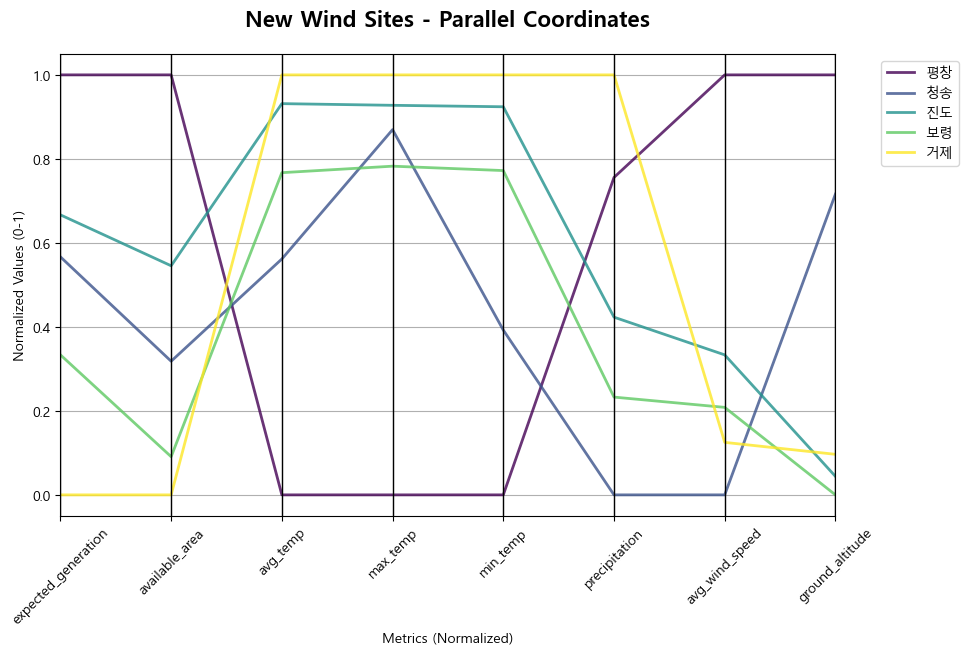

In [ ]:
# 평행 좌표 플롯 - 신규 추천지 비교
def create_parallel_coordinates(new_df):
    plt.figure(figsize=(10, 6))
    # 숫자형 컬럼만 정규화
    numeric_cols = new_df.select_dtypes(include=[float, int]).columns
    normalized_df = new_df.copy()
    for col in numeric_cols:
        min_val = new_df[col].min()
        max_val = new_df[col].max()
        normalized_df[col] = (new_df[col] - min_val) / (max_val - min_val)
    normalized_df['site_name'] = new_df['site_name']  
    parallel_coordinates(
        normalized_df, 
        'site_name', 
        cols=numeric_cols.tolist(), 
        color=plt.cm.viridis(np.linspace(0,1,len(new_df))),
        alpha=0.8,
        linewidth=2
    )
    plt.title('New Wind Sites - Parallel Coordinates', fontsize=16, weight='bold', pad = 20)
    plt.xlabel('Metrics (Normalized)')
    plt.ylabel('Normalized Values (0-1)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

create_parallel_coordinates(new_sites)

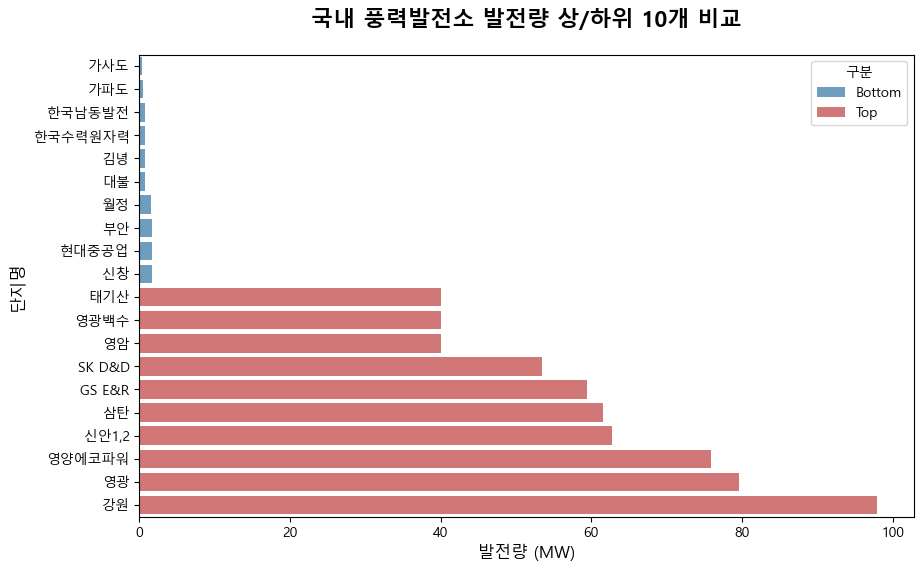

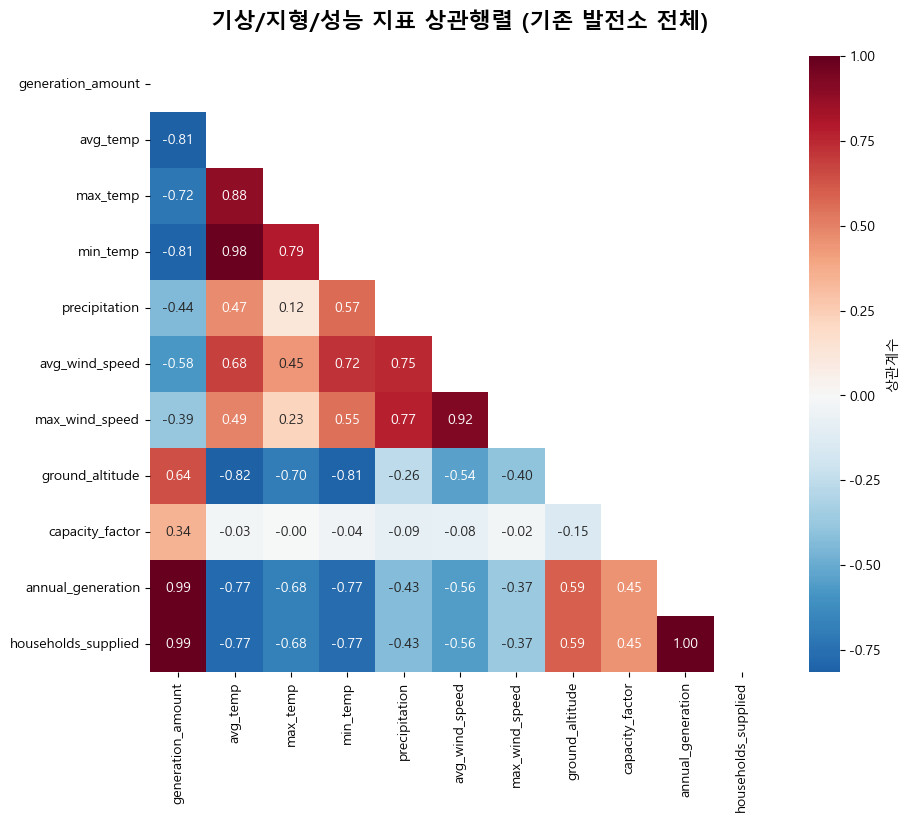

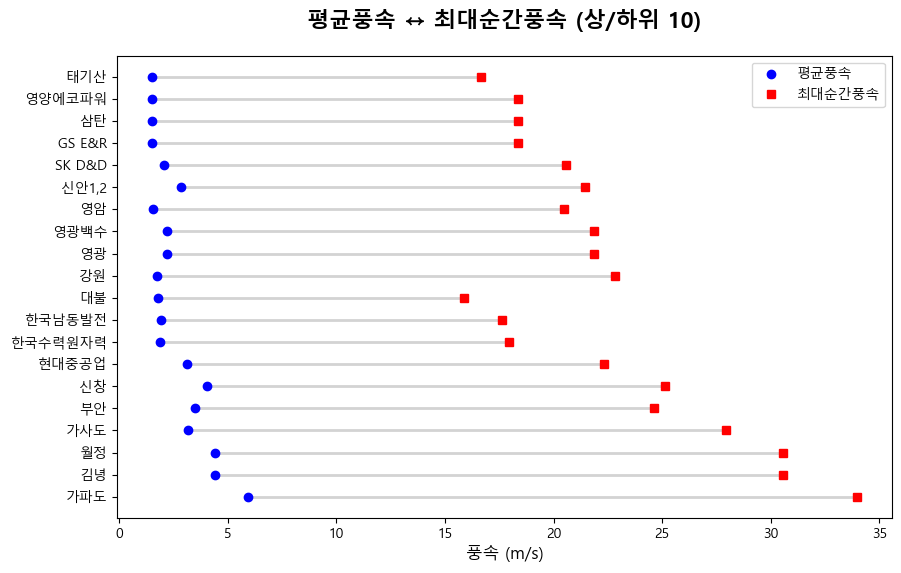

In [78]:
# 상·하위 10개 발전량 막대그래프
def create_bar_top_bottom(existing_df):
    plt.figure(figsize=(10, 6))

    plot_df = existing_df.sort_values('generation_amount', ascending=True)

    ax = sns.barplot(
        data=plot_df, 
        y='plant_name', 
        x='generation_amount', 
        hue='category', 
        dodge=False,
        palette={'Top': '#d62728', 'Bottom': '#1f77b4'},  
        alpha=0.7
    )

    ax.set_title('국내 풍력발전소 발전량 상/하위 10개 비교', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('발전량 (MW)', fontsize=12)
    ax.set_ylabel('단지명', fontsize=12)
    ax.legend(title='구분', loc='upper right')
    plt.show()


# 상관행렬 히트맵
def create_corr_heatmap(existing_df):
    matrix = [
        'generation_amount', 'avg_temp', 'max_temp', 'min_temp', 'precipitation',
        'avg_wind_speed', 'max_wind_speed', 'ground_altitude', 'capacity_factor',
        'annual_generation', 'households_supplied'
    ]
    cols = [c for c in matrix if c in existing_df.columns]

    mat = existing_df[cols].apply(pd.to_numeric, errors='coerce')
    mat = mat.dropna(how='all', axis=1)

    if mat.shape[1] < 2:
        print('[건너뜀] 히트맵: 상관을 계산할 열이 2개 미만입니다.')
        return

    corr = mat.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr, 
        mask=mask, 
        annot=True, 
        fmt='.2f', 
        cmap='RdBu_r', 
        center=0,
        cbar_kws={'label': '상관계수'}
    )
    plt.title('기상/지형/성능 지표 상관행렬 (기존 발전소 전체)', fontsize=16, weight='bold', pad=20)
    plt.show()


# 평균풍속 ↔ 최대순간풍속 덤벨 플롯
def create_dumbbell_plot(existing_df):
    df = existing_df.dropna(subset=['avg_wind_speed', 'max_wind_speed']).copy()

    df['range'] = (df['max_wind_speed'] - df['avg_wind_speed']).abs()
    df = df.sort_values(['category', 'range', 'plant_name'], ascending=[True, False, True])

    plt.figure(figsize=(10, 6))
    y = np.arange(len(df))

    # 연결선
    plt.hlines(y=y, xmin=df['avg_wind_speed'], xmax=df['max_wind_speed'], color='lightgray', lw=2)

    # 점
    plt.plot(df['avg_wind_speed'], y, 'o', label='평균풍속', color='blue')
    plt.plot(df['max_wind_speed'], y, 's', label='최대순간풍속', color='red')

    plt.yticks(y, df['plant_name'])
    plt.xlabel('풍속 (m/s)', fontsize=12)
    plt.title('평균풍속 ↔ 최대순간풍속 (상/하위 10)', fontsize=16, weight='bold', pad=20)
    plt.legend()
    plt.show()


create_bar_top_bottom(existing_plants)
create_corr_heatmap(existing_plants)
create_dumbbell_plot(existing_plants)


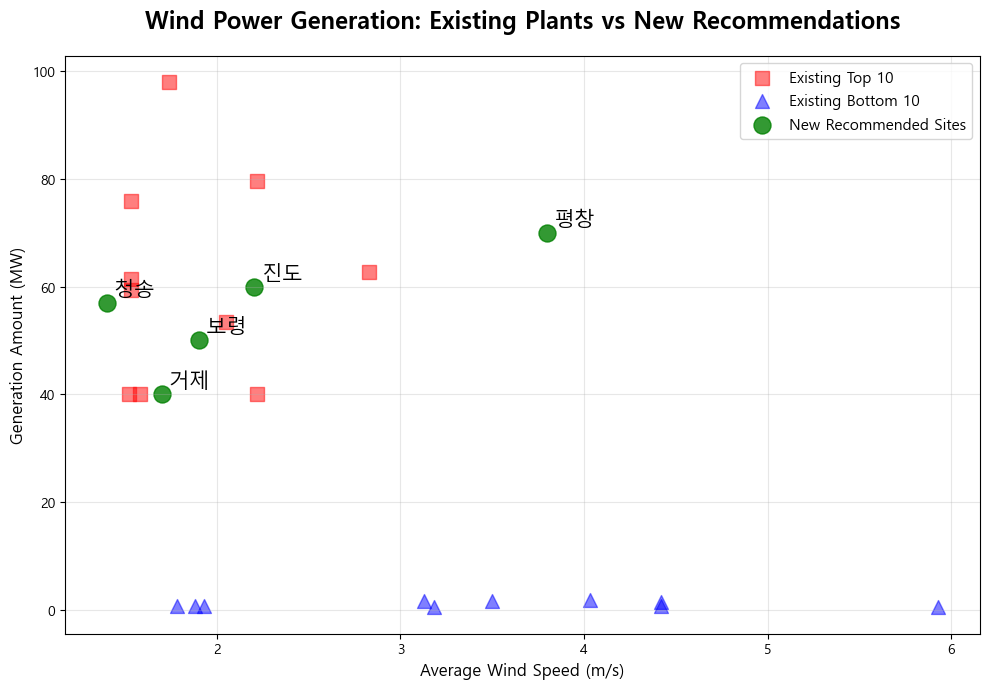

In [ ]:

# 벤치마킹 차트 - 기존 vs 신규 비교
def create_benchmarking_chart(existing_df, new_df):
        plt.figure(figsize=(10, 7))
        
        # 상위 
        top_plants = existing_df[existing_df['category'] == 'Top']
        plt.scatter(top_plants['avg_wind_speed'], top_plants['generation_amount'], 
                s=100, c='red', marker='s', label='Existing Top 10', alpha=0.5)
        
        # 하위 
        bottom_plants = existing_df[existing_df['category'] == 'Bottom']
        plt.scatter(bottom_plants['avg_wind_speed'], bottom_plants['generation_amount'], 
                s=100, c='blue', marker='^', label='Existing Bottom 10', alpha=0.5)
        
        # 신규 
        plt.scatter(new_df['avg_wind_speed'], new_df['expected_generation'], 
                s=150, c='green', marker='o', label='New Recommended Sites', alpha=0.8)
        
        # 신규에 라벨 추가
        for i, site in enumerate(new_df['site_name']):
                plt.annotate(site, (new_df['avg_wind_speed'].iloc[i], new_df['expected_generation'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=15)
        
        plt.xlabel('Average Wind Speed (m/s)', size=12)
        plt.ylabel('Generation Amount (MW)', size=12)
        plt.title('Wind Power Generation: Existing Plants vs New Recommendations', size=17, weight='bold', pad=20)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.show()


create_benchmarking_chart(existing_plants, new_sites)

<Figure size 1800x1200 with 0 Axes>

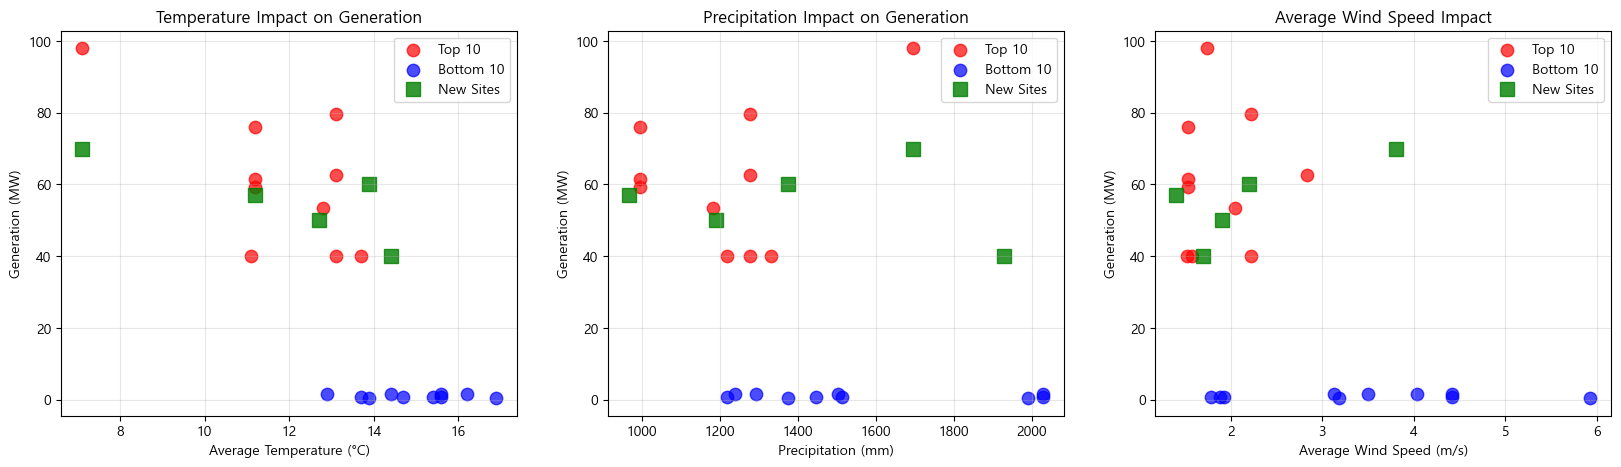

In [ ]:
# 기상 조건이 발전량에 미치는 영향 분석

def create_weather_impact_analysis(existing_df, new_df):
        plt.figure(figsize=(18, 12))
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        
        # 기존 발전소 데이터
        top_plants = existing_df[existing_df['category'] == 'Top']
        bottom_plants = existing_df[existing_df['category'] == 'Bottom']
        
        # 1. 기온 vs 발전량
        ax1 = axes[0]
        ax1.scatter(top_plants['avg_temp'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax1.scatter(bottom_plants['avg_temp'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax1.scatter(new_df['avg_temp'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax1.set_xlabel('Average Temperature (°C)')
        ax1.set_ylabel('Generation (MW)')
        ax1.set_title('Temperature Impact on Generation')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 강수량 vs 발전량
        ax2 = axes[1]
        ax2.scatter(top_plants['precipitation'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax2.scatter(bottom_plants['precipitation'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax2.scatter(new_df['precipitation'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax2.set_xlabel('Precipitation (mm)')
        ax2.set_ylabel('Generation (MW)')
        ax2.set_title('Precipitation Impact on Generation')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 평균풍속 vs 발전량 
        ax3 = axes[2]
        ax3.scatter(top_plants['avg_wind_speed'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax3.scatter(bottom_plants['avg_wind_speed'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax3.scatter(new_df['avg_wind_speed'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax3.set_xlabel('Average Wind Speed (m/s)')
        ax3.set_ylabel('Generation (MW)')
        ax3.set_title('Average Wind Speed Impact')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        

create_weather_impact_analysis(existing_plants, new_sites)

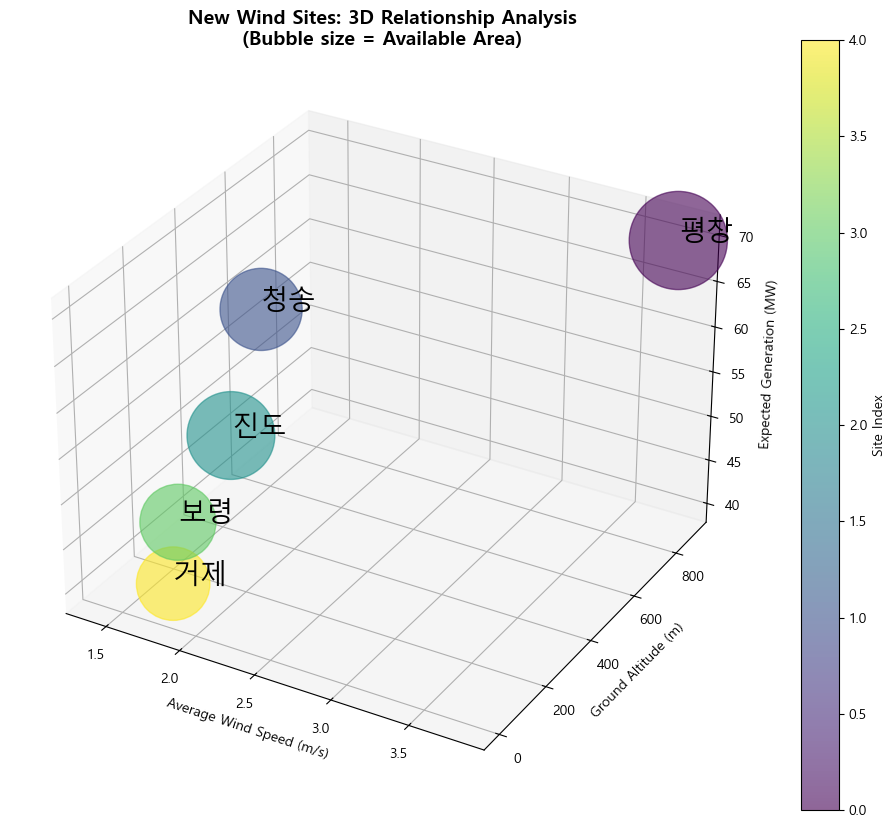

In [79]:
# 3D 산점도 - 핵심 3요소 관계 분석
def create_3d_scatter(new_df):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # 3D 산점도 (이용가능부지를 km²로 변환)
        area_km2 = new_df['available_area'] / 1000000  # m²를 km²로 변환
        scatter = ax.scatter(new_df['avg_wind_speed'], 
                        new_df['ground_altitude'], 
                        new_df['expected_generation'],
                        c=range(len(new_df)),
                        s=area_km2 * 10000,  # 점 크기는 이용가능부지 크기(km²)
                        cmap='viridis',
                        alpha=0.6)
        
        # 각 점에 라벨 추가
        for i, site in enumerate(new_df['site_name']):
                ax.text(new_df['avg_wind_speed'].iloc[i],
                        new_df['ground_altitude'].iloc[i],
                        new_df['expected_generation'].iloc[i],
                        site, fontsize=20)
                
                ax.set_xlabel('Average Wind Speed (m/s)')
                ax.set_ylabel('Ground Altitude (m)')
                ax.set_zlabel('Expected Generation (MW)')
                ax.set_title('New Wind Sites: 3D Relationship Analysis\n(Bubble size = Available Area)', size=14, weight='bold')
        
        plt.colorbar(scatter, ax=ax, label='Site Index')
        plt.show()

create_3d_scatter(new_sites)

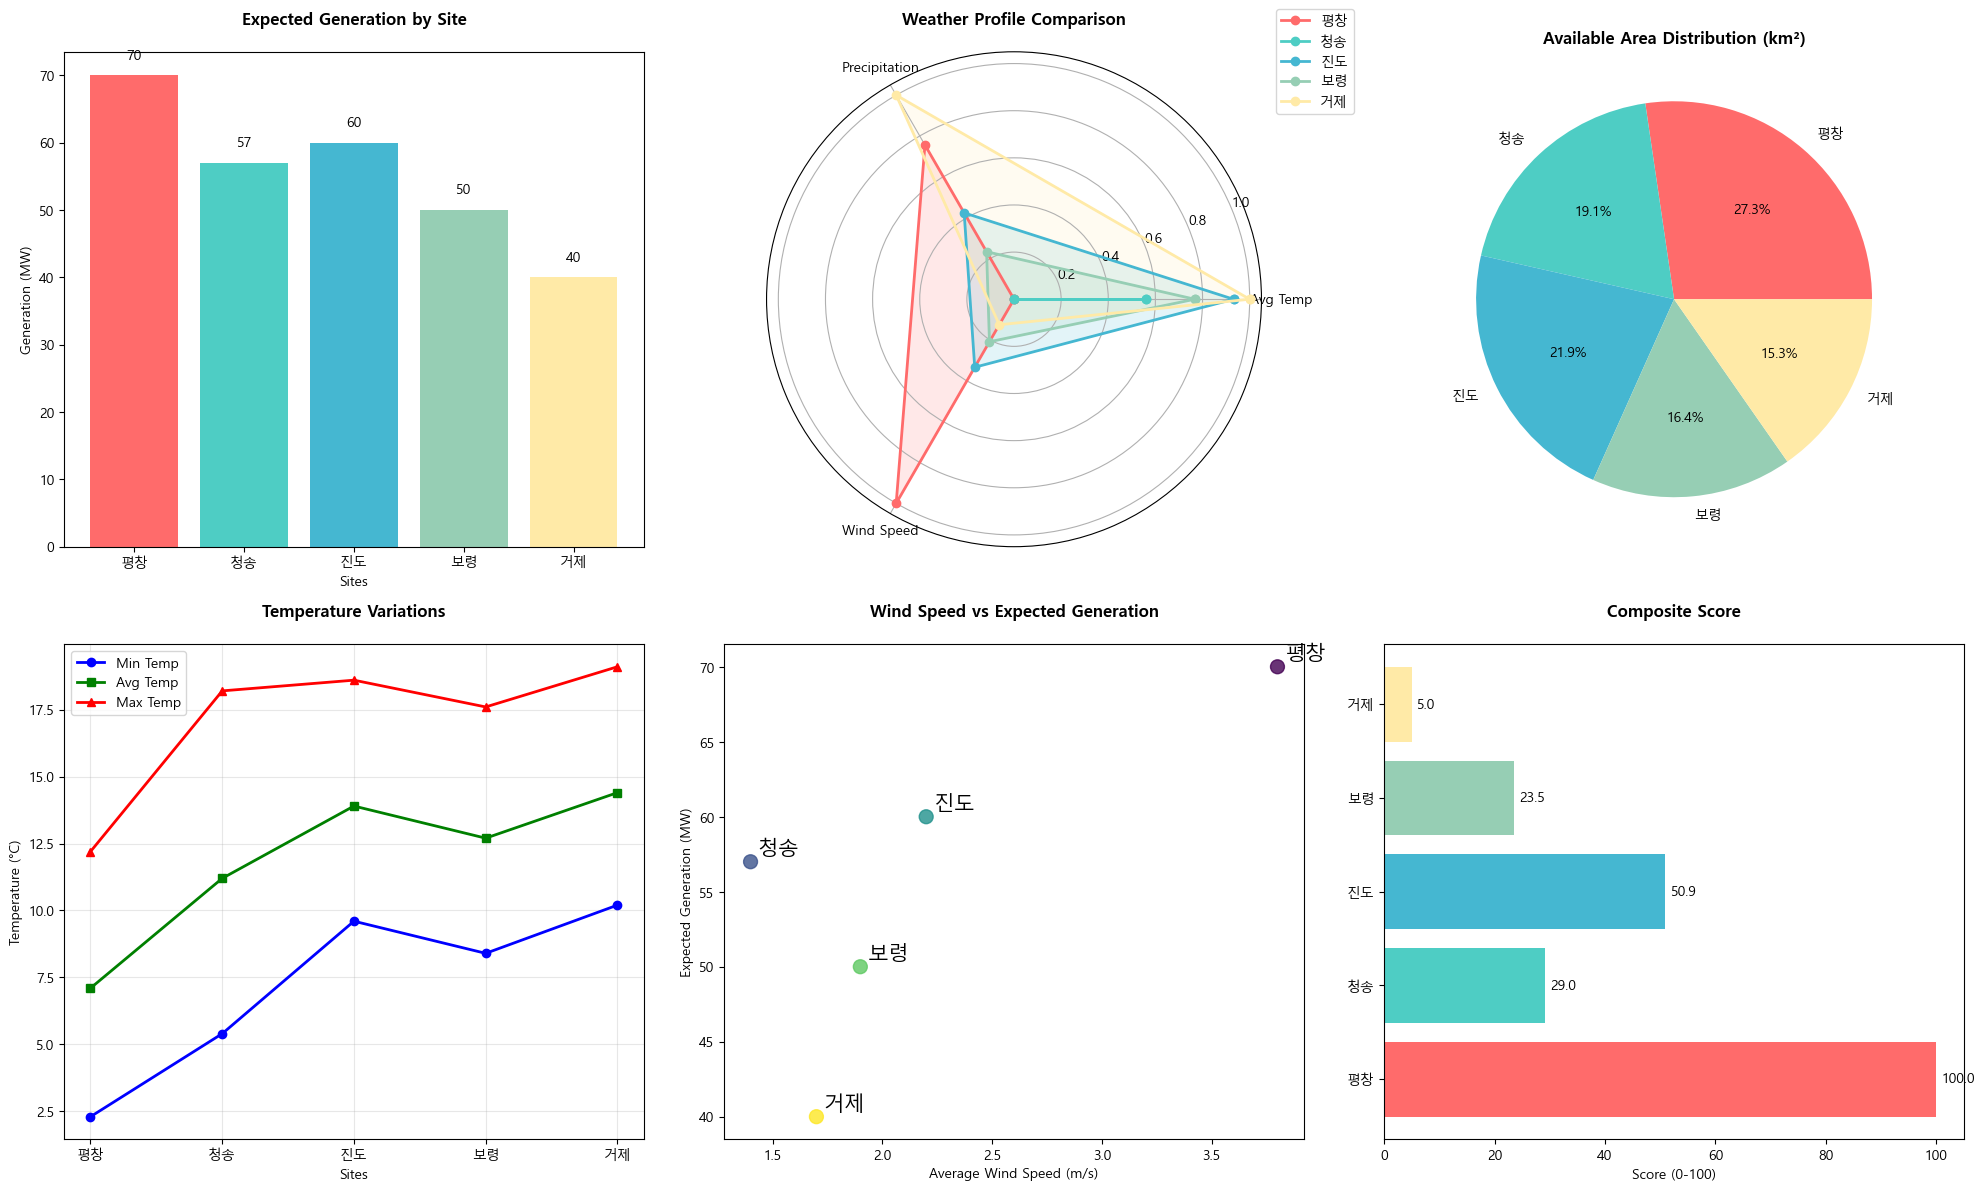

In [ ]:

# 복합 차트(신규 추천 단지 분석)

def create_dashboard(new_df):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        
    # 기본 색상
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    # 1. 예상발전량 바 차트
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(new_df)), new_df['expected_generation'].fillna(0), 
                    color=[base_colors[i % len(base_colors)] for i in range(len(new_df))])
    ax1.set_title('Expected Generation by Site', weight='bold', pad=20)
    ax1.set_xlabel('Sites')
    ax1.set_ylabel('Generation (MW)')
    ax1.set_xticks(range(len(new_df)))
    ax1.set_xticklabels(new_df['site_name'])
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2, f'{height:.0f}', ha='center', va='bottom')
    
    # 2. 기상조건 레이더 차트 (모든 장소 한번에 비교)
    ax2 = axes[0, 1]
    ax2.remove()
    ax2 = fig.add_subplot(2, 3, 2, projection='polar')

    weather_metrics = ['avg_temp', 'precipitation', 'avg_wind_speed']  # humidity 제거
    weather_labels = ['Avg Temp', 'Precipitation', 'Wind Speed']

    angles = [n / float(len(weather_metrics)) * 2 * pi for n in range(len(weather_metrics))]
    angles += angles[:1]

    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i in range(len(new_df)):
        weather_data = new_df[weather_metrics].iloc[i].fillna(0)
        weather_max = new_df[weather_metrics].max()
        weather_min = new_df[weather_metrics].min()
        # 0으로 나누는 오류 방지
        weather_norm = (weather_data - weather_min) / (weather_max - weather_min).replace(0, 1)
        
        values = weather_norm.values.tolist()
        values += values[:1]
        
        ax2.plot(angles, values, 'o-', linewidth=2, color=base_colors[i % len(base_colors)], label=new_df['site_name'].iloc[i])
        ax2.fill(angles, values, alpha=0.15, color=base_colors[i % len(base_colors)])

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(weather_labels)
    ax2.set_title('Weather Profile Comparison', weight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    # 3. 부지조건 파이 차트
    ax3 = axes[0, 2]
    sizes = (new_df['available_area'] / 1000000)
    mask = sizes > 0
    if mask.sum() > 0:
        sizes_nonzero = sizes[mask]
        labels_nonzero = new_df['site_name'][mask]
        colors = [base_colors[i % len(base_colors)] for i in range(len(sizes_nonzero))]
        wedges, texts, autotexts = ax3.pie(
            sizes_nonzero,
            labels=labels_nonzero,
            autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
            colors=colors
        )
    else:
        ax3.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=14)
    ax3.set_title('Available Area Distribution (km²)', weight='bold')
    
    # 4. 기온 변화 선 그래프
    ax4 = axes[1, 0]
    x_pos = range(len(new_df))
    ax4.plot(x_pos, new_df['min_temp'].fillna(0), 'b-o', label='Min Temp', linewidth=2)
    ax4.plot(x_pos, new_df['avg_temp'].fillna(0), 'g-s', label='Avg Temp', linewidth=2)
    ax4.plot(x_pos, new_df['max_temp'].fillna(0), 'r-^', label='Max Temp', linewidth=2)
    ax4.set_title('Temperature Variations', weight='bold', pad=20)
    ax4.set_xlabel('Sites')
    ax4.set_ylabel('Temperature (°C)')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(new_df['site_name'])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. 풍속-발전량 산점도
    ax5 = axes[1, 1]
    scatter = ax5.scatter(new_df['avg_wind_speed'].fillna(0), new_df['expected_generation'].fillna(0),
                            s=100, c=range(len(new_df)), cmap='viridis', alpha=0.8)
    ax5.set_title('Wind Speed vs Expected Generation', weight='bold', pad=20)
    ax5.set_xlabel('Average Wind Speed (m/s)')
    ax5.set_ylabel('Expected Generation (MW)')
    for i, site in enumerate(new_df['site_name']):
        ax5.annotate(site, (new_df['avg_wind_speed'].fillna(0).iloc[i], 
                            new_df['expected_generation'].fillna(0).iloc[i]),
                            xytext=(5, 5), textcoords='offset points', fontsize=15)
    
    # 6. 종합점수 바 차트
    ax6 = axes[1, 2]
    area_km2 = (new_df['available_area'] / 1_000_000).fillna(0)
    weights = [0.4, 0.4, 0.2]
    scores = []
    
    for i in range(len(new_df)):
        gen_norm = (new_df['expected_generation'].iloc[i] - new_df['expected_generation'].min()) / \
                    (new_df['expected_generation'].max() - new_df['expected_generation'].min() or 1)
        wind_norm = (new_df['avg_wind_speed'].iloc[i] - new_df['avg_wind_speed'].min()) / \
                    (new_df['avg_wind_speed'].max() - new_df['avg_wind_speed'].min() or 1)
        area_norm = (area_km2.iloc[i] - area_km2.min()) / (area_km2.max() - area_km2.min() or 1)
        score = gen_norm * weights[0] + wind_norm * weights[1] + area_norm * weights[2]
        scores.append(score * 100)
    
    bars = ax6.barh(range(len(new_df)), scores, color=[base_colors[i % len(base_colors)] for i in range(len(new_df))])
    ax6.set_title('Composite Score', weight='bold', pad=20)
    ax6.set_xlabel('Score (0-100)')
    ax6.set_yticks(range(len(new_df)))
    ax6.set_yticklabels(new_df['site_name'])
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax6.text(width + 1, bar.get_y() + bar.get_height()/2., f'{width:.1f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

create_dashboard(new_sites)


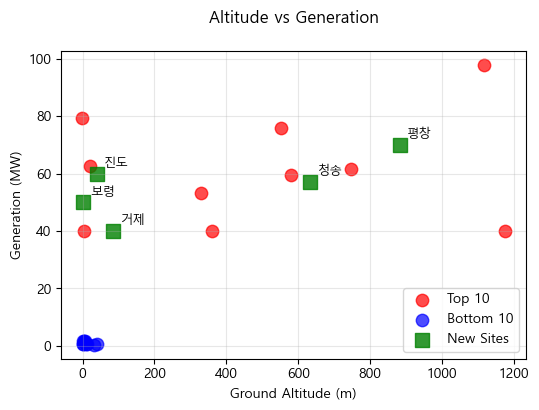

In [ ]:
# 발전량 vs 지면고도 (Top 10 / Bottom 10 / New Sites)
def create_altitude_vs_generation(existing_df, new_df, axes=None):
    # 기존 발전소 상위/하위
    top_plants = existing_df[existing_df['category'] == 'Top']
    bottom_plants = existing_df[existing_df['category'] == 'Bottom']

    if axes is None:
        fig, ax1 = plt.subplots(figsize=(6,4))
    else:
        ax1 = axes

    # 상위
    ax1.scatter(top_plants['ground_altitude'], top_plants['generation_amount'],
                c='red', alpha=0.7, s=80, label='Top 10')

    # 하위
    ax1.scatter(bottom_plants['ground_altitude'], bottom_plants['generation_amount'],
                c='blue', alpha=0.7, s=80, label='Bottom 10')

    # 신규
    ax1.scatter(new_df['ground_altitude'], new_df['expected_generation'],
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')

    # 라벨링 
    for i, site in enumerate(new_df['site_name']):
        ax1.annotate(site, 
                    (new_df['ground_altitude'].iloc[i], new_df['expected_generation'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    ax1.set_xlabel('Ground Altitude (m)')
    ax1.set_ylabel('Generation (MW)')
    ax1.set_title('Altitude vs Generation', pad = 20)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

create_altitude_vs_generation(existing_plants, new_sites)
